# Introduction

### About The Data

The dataset contains cases from a study that was conducted between
   1958 and 1970 at the University of Chicago's Billings Hospital on
   the survival of patients who had undergone surgery for breast
   cancer.


source: http://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival

### General Information

**age:** Age of patient at time of operation (numerical)


**year:** Patient's year of operation (year - 1900, numerical)


**axillary:** Number of positive axillary nodes detected (numerical)


**status:** Survival status (class attribute)
    * 1 = the patient survived 5 years or longer
    * 2 = the patient died within 5 year

# Research Question & Hypothesis

* Is there any correlation between age, year and axillary node to survival?
* Build prediction model to predict survival. Using Binary Logistic Regression

## Experimental Design

### Preparations

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm 
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [143]:
df = pd.read_csv('data/haberman.csv')

In [144]:
df.head()

,age,year,axillary,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [145]:
df.describe()

,age,year,axillary,status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


### Check for null values

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
age         306 non-null int64
year        306 non-null int64
axillary    306 non-null int64
status      306 non-null int64
dtypes: int64(4)
memory usage: 9.7 KB


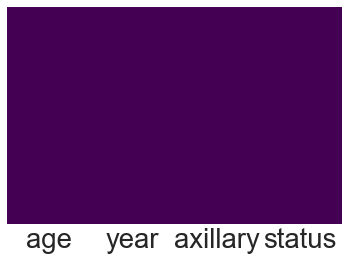

In [147]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

There are no missing values

### Numerical Data Distribution

let's look how the data are distributed

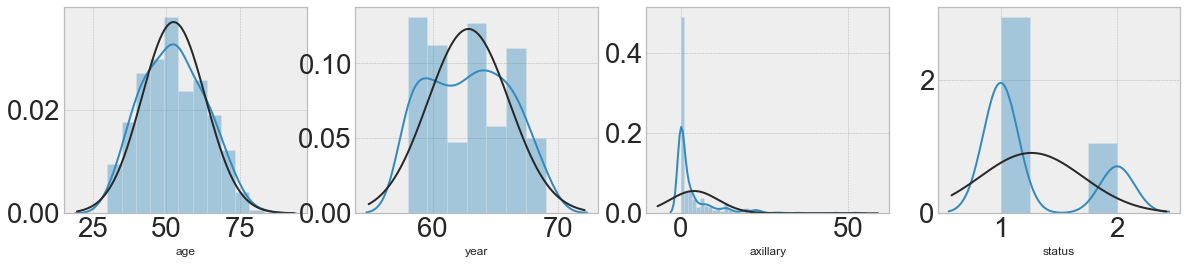

In [148]:
plt.figure(figsize = (20,22))

for i in range(0,4):
    plt.subplot(5,4,i+1)
    sns.distplot(df[df.columns[i]], fit=norm)

### Check for outliers

we will use boxplot to check for outliers

In [149]:
variables = [column for column in df]
variables.remove('status')

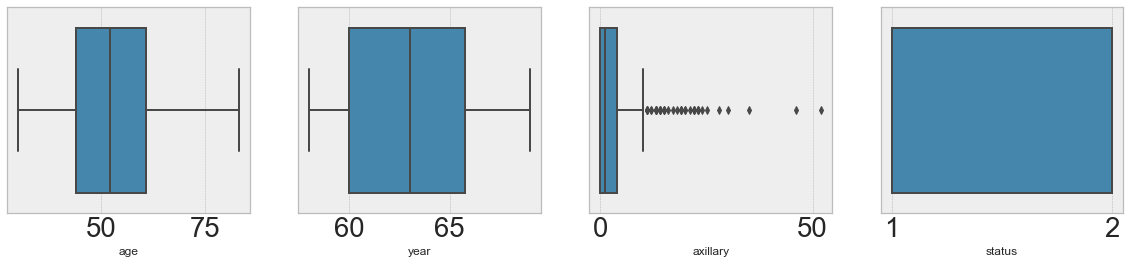

In [150]:
plt.figure(figsize=(20,22))

for i in range(0,4):
    plt.subplot(5,4,i+1)
    sns.boxplot(df[df.columns[i]])

There are many extreme values in axillary, let's try to remove them

### Winsorizing

Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. 

In [151]:
def winsor(x, multiplier=3): 
    upper= x.median() + x.std()*multiplier
    for limit in np.arange(0.001, 0.20, 0.001):
        if np.max(winsorize(x,(0,limit))) < upper:
            return limit
    return None

In [152]:
from scipy.stats.mstats import winsorize

df_clean = df.copy()
df_clean['axillary'] = winsorize(df_clean['axillary'], (0, winsor(df_clean['axillary'], 3)))
df_clean

,age,year,axillary,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


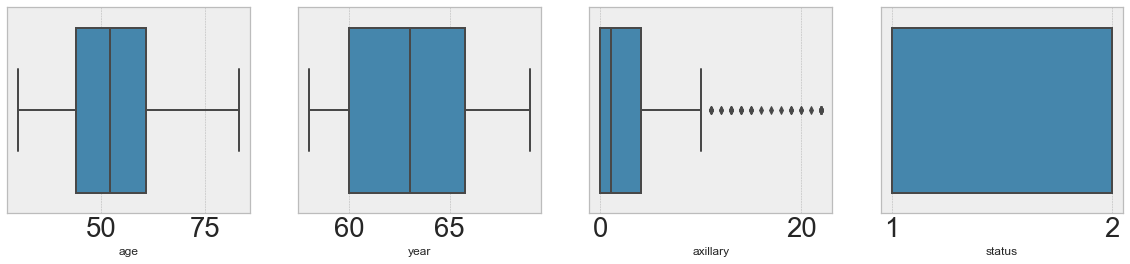

In [153]:
plt.figure(figsize=(20,22))

for i in range(0,4):
    plt.subplot(5,4,i+1)
    sns.boxplot(df_clean[df_clean.columns[i]])

### Correlation

Now, we will try to find which features are strongly correlated with `status`

In [154]:
corr_matrix = df_clean.corr()
corr_list = corr_matrix.status.abs().sort_values(ascending=False).index[0:]

corr_list

Index(['status', 'axillary', 'age', 'year'], dtype='object')

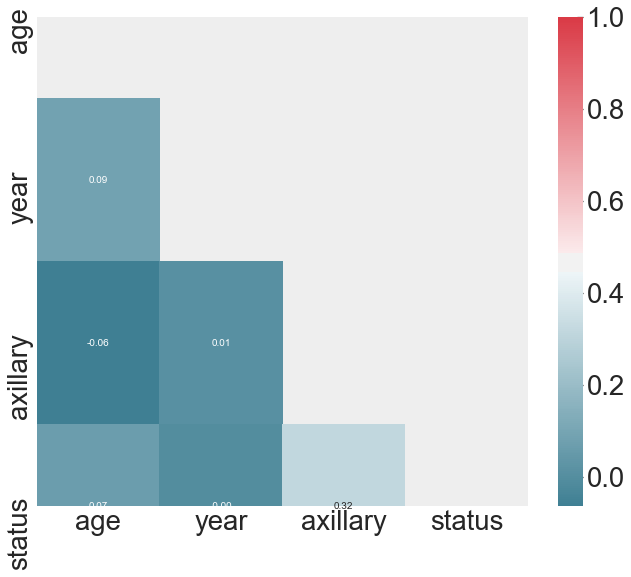

In [155]:
plt.figure(figsize=(11,9))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=2.5)

Survival status has the highest correlation with axillary. Other correlation degree are very low with each other. 

### Modelling

#### Creating train and test group

In [156]:
feature_cols = ['age', 'axillary']
X = df_clean[feature_cols]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

#### Logistic Regression

In [157]:
lr = LogisticRegression(random_state=40)
lr.fit(X_train, y_train)

/Users/tegardp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=40, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [158]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.74
Accuracy in Test  Group   : 0.77


#### Confusion Matrix

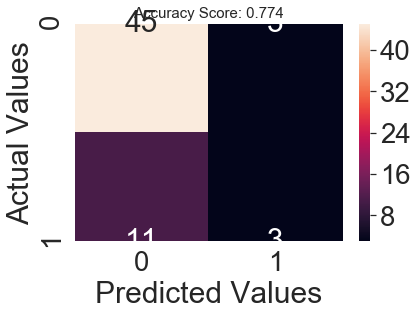

In [159]:
from sklearn.metrics import confusion_matrix as cm

predictions = lr.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

In [161]:
pred_test  = lr.predict(X_test)
pred_train = lr.predict(X_train)

cm = confusion_matrix(y_test,pred_test)
cm

array([[45,  3],
       [11,  3]])

#### Performance Measurements

In [164]:
quality_pred = LogisticRegression(random_state=40)
quality_pred.fit(X_train,y_train)

/Users/tegardp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=40, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [166]:
confusion_matrix_train = confusion_matrix(y_train,pred_train)
confusion_matrix_test = confusion_matrix(y_test,pred_test)

print('Confusion Matrix Train Data', '--'*20, confusion_matrix_train, sep='\n')
print('Confusion Matrix Test Data', '--'*20, confusion_matrix_test, sep='\n')

Confusion Matrix Train Data
----------------------------------------
[[166  11]
 [ 53  14]]
Confusion Matrix Test Data
----------------------------------------
[[45  3]
 [11  3]]


In [175]:
TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

print("(Total) True Negative       :", TN)
print("(Total) True Positive       :", TP)
print("(Total) False Positive      :", FP)
print("(Total) False Negative      :", FN)

(Total) True Negative       : 45
(Total) True Positive       : 3
(Total) False Positive      : 3
(Total) False Negative      : 11


In [176]:
FP+FN 

14

#### Accuracy

In [171]:
print("Accuracy Score of Our Model     : ",  quality_pred.score(X_test, y_test))

Accuracy Score of Our Model     :  0.7741935483870968


#### Error Rate

In [173]:
Error_Rate = 1- (accuracy_score(y_test, pred_test))  
Error_Rate

0.22580645161290325